In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from wordcloud import WordCloud

import nltk
nltk.download('wordnet')
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
!pip install contractions
import contractions
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
     |████████████████████████████████| 321 kB 5.2 MB/s 
     |████████████████████████████████| 284 kB 53.7 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85435 sha256=bab94b5dbfa3dd197b20bf2da6169854a5b6c3428cccc7b6391d9caae3b5d954
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

# 1. Exploration du jeu de données

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATASET_FILE = "/content/drive/MyDrive/S9/IAAppliquee/NLP/dataset.csv"
dataset_df = pd.read_csv(DATASET_FILE)
dataset_df

,text,stars
0,I've only had food from here once and it wasn'...,1
1,I will never return here again. Ever. I was ...,1
2,I wish my experience was great as others. I di...,1
3,Are the rosemary grapefruit scones supposed to...,1
4,Our takeout order was half wrong. Food was mis...,1
...,...,...
24995,I was a loyal fan of Aroy before the ownership...,5
24996,Stopped here for a bite while wandering around...,5
24997,"A quiet place with excellent food, great music...",5
24998,Super delicious food. Awesome vibe. I suffered...,5


## 1.1 Répartition des avis clients en fonction du nombre d'étoiles

In [ ]:
stars_columns = dataset_df.stars
stars_columns

0        1
1        1
2        1
3        1
4        1
        ..
24995    5
24996    5
24997    5
24998    5
24999    5
Name: stars, Length: 25000, dtype: int64

In [ ]:
stars_columns.value_counts()

5    5000
4    5000
3    5000
2    5000
1    5000
Name: stars, dtype: int64

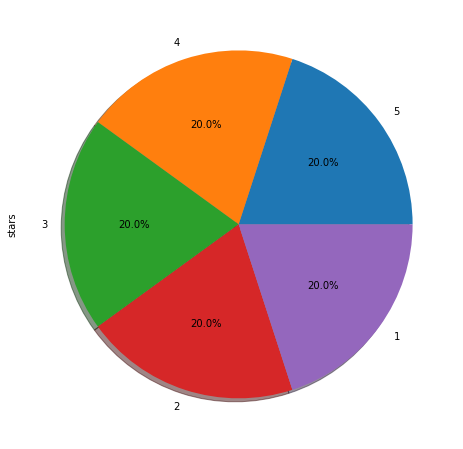

In [ ]:
stars_columns.value_counts().plot(kind="pie", figsize=(10, 8), autopct="%1.1f%%", shadow=True)

## 1.2 Distribution de la longueur (nombre de mots) des avis clients

In [ ]:
dataset_df["length"] = dataset_df["text"].apply(lambda x: len(x.split()))
dataset_df

,text,stars,length
0,I've only had food from here once and it wasn'...,1,68
1,I will never return here again. Ever. I was ...,1,87
2,I wish my experience was great as others. I di...,1,166
3,Are the rosemary grapefruit scones supposed to...,1,81
4,Our takeout order was half wrong. Food was mis...,1,32
...,...,...,...
24995,I was a loyal fan of Aroy before the ownership...,5,75
24996,Stopped here for a bite while wandering around...,5,55
24997,"A quiet place with excellent food, great music...",5,32
24998,Super delicious food. Awesome vibe. I suffered...,5,41


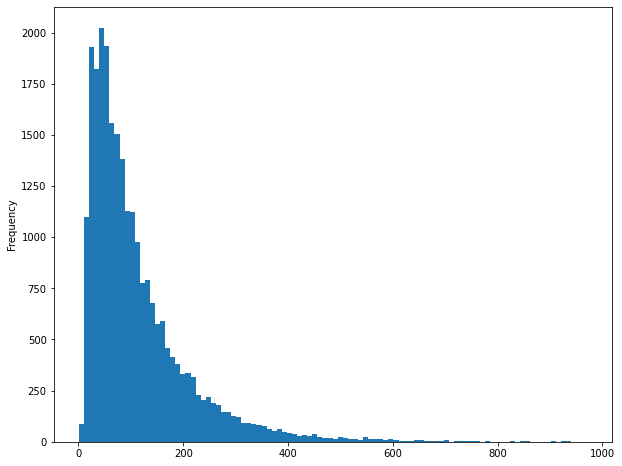

In [ ]:
dataset_df.length.plot(kind="hist", bins=100, figsize=(10, 8))

## 1.3 Distribution de la longueur des avis clients en fonction du nombre d'étoiles des avis

Text(0.5, 1.0, "Répartition des longueurs des avis en fonction du nombre d'étoiles")

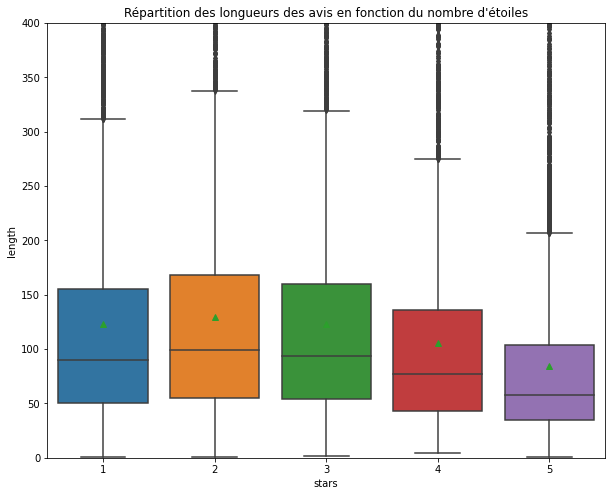

In [ ]:
plt.figure(figsize=(10, 8))

ax = sns.boxplot(x=dataset_df.stars ,
            y=dataset_df.length,
            showmeans=True,
            )
ax.set_ylim(0, 400)

ax.set_title("Répartition des longueurs des avis en fonction du nombre d'étoiles")

# 2. Pré-traitement du jeu de données

On se concentre sur les avis négatifs : 1 ou 2 étoiles

In [ ]:
df_avis_negatifs = dataset_df.loc[dataset_df['stars'].isin([1,2])]
df_avis_negatifs.head()

,text,stars,length
0,I've only had food from here once and it wasn'...,1,68
1,I will never return here again. Ever. I was ...,1,87
2,I wish my experience was great as others. I di...,1,166
3,Are the rosemary grapefruit scones supposed to...,1,81
4,Our takeout order was half wrong. Food was mis...,1,32


Objectifs:
- Tokenization
- Normalisation du texte 
- Lemmatisation
- Effacement des stop words (pas les négatifs)

In [ ]:
#Nouveau dataframe post traitement 
df_post_traitement = pd.DataFrame()

Tokenisation et normalisation

In [ ]:
import string
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

def tokenization(text): 
  return tokenizer.tokenize(contractions.fix(text.lower().translate(str.maketrans('', '', string.punctuation))))

df_post_traitement['text_token']= df_avis_negatifs.text.apply(tokenization)
df_post_traitement.head()

Gestion des stop_words

In [ ]:
nltk.download('stopwords')
stop_words=nltk.corpus.stopwords.words('english')

#Répertoire des stop_words negatifs
stop_words_negatifs = ['no','never', 'not', 'nor', "don't", "aren't", 'didn', "didn't", 'doesn', "doesn't",'aren', 'couldn', "couldn't", 'hadn', "hadn't", 'hasn',"hasn't", 'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

#Les stop_words négatifs sont enlevés dans un premier temps
stop_words_sans_neg = [x for x in stop_words if x not in stop_words_negatifs]

def enlever_stop_words_sans_neg(tokens):
  return [x for x in tokens if x not in stop_words_sans_neg]

df_post_traitement['text_token_stop_words']= df_post_traitement.text_token.apply(enlever_stop_words_sans_neg)
df_post_traitement.head()


In [ ]:
#Ici on associe les stop words négatifs répertoriés dans stop_words_negatifs aux mots qui leur succèdent 
#pour garder des expressions négatives plus exploitables

def associations(tokens):
  index = []
  for i in range(len(tokens)):
    if tokens[i] in stop_words_negatifs:
      index.append(i)
  for x in index :
    if x < len(index) :
      tokens[x+1] = tokens[x] +" "+ tokens[x+1]
    else :
      tokens[x] = tokens[x]
  return tokens

  
df_post_traitement['text_token_association_des_neg']= df_post_traitement.text_token_stop_words.apply(associations)
df_post_traitement.head()

,text_token,text_token_stop_words,text_token_association_des_neg,text_pos_tag,text_lem
0,"[I, have, only, had, food, from, here, once, a...","[I, food, not memorable, panang, curry, balanc...","[I, food, not memorable, panang, curry, balanc...","[(I, PRP), (food, NN), (not memorable, JJ), (p...",I food not memorable panang curry balance flav...
1,"[i, will, never, return, here, again, ever, i,...","[never return, ever, sitting, booth, waiting, ...","[never return, ever, sitting, booth, waiting, ...","[(never return, NN), (ever, RB), (sitting, VBG...",never return ever sit booth wait dinner come s...
2,"[i, wish, my, experience, was, great, as, othe...","[wish, experience, great, others, dined, wedne...","[wish, experience, great, others, dined, wedne...","[(wish, JJ), (experience, NN), (great, JJ), (o...",wish experience great others din wednesday nig...
3,"[are, the, rosemary, grapefruit, scones, suppo...","[rosemary, grapefruit, scones, supposed, taste...","[rosemary, grapefruit, scones, supposed, taste...","[(rosemary, JJ), (grapefruit, NN), (scones, NN...",rosemary grapefruit scone suppose taste like w...
4,"[our, takeout, order, was, half, wrong, food, ...","[takeout, order, half, wrong, food, missing, p...","[takeout, order, half, wrong, food, missing, p...","[(takeout, IN), (order, NN), (half, NN), (wron...",takeout order half wrong food miss portion siz...


In [ ]:
#Les stop_words négatifs étant maintenant regroupés avec le mot suivant, on enlève les mots négatifs seuls

def enlever_stop_words_neg(tokens):
  return [x for x in tokens if x not in stop_words_negatifs]

df_post_traitement['text_token_stop_words']= df_post_traitement.text_token_association_des_neg.apply(enlever_stop_words_neg)
df_post_traitement[['text_token_stop_words']].head()

Pos-Tagging

In [ ]:
def pos_tagging(tokens):
  return nltk.pos_tag(tokens)

df_post_traitement['text_pos_tag'] = df_post_traitement.text_token_stop_words.apply(pos_tagging)

df_post_traitement.head()

,text_token,text_token_stop_words,text_token_association_des_neg,text_pos_tag,text_lem
0,"[I, have, only, had, food, from, here, once, a...","[I, food, not memorable, panang, curry, balanc...","[I, food, not, not memorable, panang, curry, b...","[(I, PRP), (food, NN), (not memorable, JJ), (p...",I food not memorable panang curry balance flav...
1,"[i, will, never, return, here, again, ever, i,...","[never return, ever, sitting, booth, waiting, ...","[never, never return, ever, sitting, booth, wa...","[(never return, NN), (ever, RB), (sitting, VBG...",never return ever sit booth wait dinner come s...
2,"[i, wish, my, experience, was, great, as, othe...","[wish, experience, great, others, dined, wedne...","[wish, experience, great, others, dined, wedne...","[(wish, JJ), (experience, NN), (great, JJ), (o...",wish experience great others din wednesday nig...
3,"[are, the, rosemary, grapefruit, scones, suppo...","[rosemary, grapefruit, scones, supposed, taste...","[rosemary, grapefruit, scones, supposed, taste...","[(rosemary, JJ), (grapefruit, NN), (scones, NN...",rosemary grapefruit scone suppose taste like w...
4,"[our, takeout, order, was, half, wrong, food, ...","[takeout, order, half, wrong, food, missing, p...","[takeout, order, half, wrong, food, missing, p...","[(takeout, IN), (order, NN), (half, NN), (wron...",takeout order half wrong food miss portion siz...


Lemmatisation

In [ ]:
lem = WordNetLemmatizer()

def lemmatisation(tokens_tag):
  liste = list()
  for word, tag in tokens_tag:
    if tag.startswith('J'):
      liste.append(lem.lemmatize(word, 'a'))
    elif tag.startswith('V'):
      liste.append(lem.lemmatize(word, 'v'))
    elif tag.startswith('N'):
      liste.append(lem.lemmatize(word, 'n'))
    elif tag.startswith('R'):
      liste.append(lem.lemmatize(word, 'r'))
    else : 
      liste.append(lem.lemmatize(word))
  return " ".join(liste)

In [ ]:
liste = df_post_traitement.text_pos_tag.apply(lemmatisation)
df_post_traitement['text_lem'] = pd.DataFrame(liste)
df_post_traitement[['text_token_stop_words','text_lem']].head()

Vectorisation



In [ ]:
vectorizer = TfidfVectorizer(min_df=0.01, max_df=0.8)

x = vectorizer.fit_transform(df_post_traitement['text_lem'])

tfidf_df = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names())


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
tfidf_df.head()

,10,100,12,15,20,25,30,40,45,50,able,absolutely,acknowledge,across,act,actual,actually,add,afternoon,ago,agree,ahead,allow,almost,alone,along,already,alright,also,although,always,amaze,ambiance,amount,annoy,another,answer,anymore,anyone,anything,...,watch,water,way,wed,week,weekend,weird,well,whatever,white,whole,wife,window,wine,wing,wish,within,without,woman,wonder,wonderful,word,work,worker,world,worst,worth,would,wow,wrap,write,wrong,yeah,year,yell,yelp,yes,yet,young,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200602,...,0.0,0.000000,0.164123,0.0,0.000000,0.0,0.0,0.14049,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.120292,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.161087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.100190,...,0.0,0.000000,0.000000,0.0,0.114348,0.0,0.0,0.00000,0.0,0.1266,0.000000,0.0,0.0,0.0,0.0,0.122885,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.168039,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0000,0.188954,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.098437,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142414,0.0,0.0,0.0,0.503369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
model = NMF(n_components=15, init='random', random_state=0)
W = model.fit_transform(x.toarray())
H= model.components_
H

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


array([[0.02883725, 0.00124869, 0.        , ..., 0.00505051, 0.0023561 ,
        0.        ],
       [0.0096487 , 0.00761556, 0.00398164, ..., 0.01550371, 0.03176955,
        0.02096986],
       [0.02757643, 0.00681951, 0.01266523, ..., 0.01390662, 0.00959628,
        0.        ],
       ...,
       [0.01072263, 0.00819574, 0.        , ..., 0.00291282, 0.00245936,
        0.01276655],
       [0.01079789, 0.0027439 , 0.02864149, ..., 0.        , 0.        ,
        0.        ],
       [0.01984804, 0.        , 0.01003026, ..., 0.        , 0.        ,
        0.00062129]])

In [ ]:
W_df = pd.DataFrame(W)
H_df = pd.DataFrame(H)

Meilleurs topics

In [ ]:
def display_topics(feature_names, num_top_words, topic_names=None):
    topic_tokens = []
    for ix, topic in enumerate(H):
        #print topic, topic number, and top words
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i] \
             for i in topic.argsort()[:-num_top_words - 1:-1]]))
        topic_tokens.append(", ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))
    return topic_tokens

index_topics = ['Installation', 'Manager', 'Bar', 'Hamburger', 'Sushi', 'Sandwich','Attente', 'Problème de commande', 'Serveurs', 'Pizza', 'Prix', 'Evolution', 'Coffee', 'Plat mexicain', 'Poulet curry'  ]
topics_tokens = display_topics(vectorizer.get_feature_names(), 15)
topics_df = pd.DataFrame(topics_tokens, columns=["Mots"], index=index_topics)
topics_df


Topic  0
come, table, server, waitress, ask, waiter, back, take, check, sit, bring, seat, water, meal, bill

Topic  1
say, would, tell, call, give, could, manager, make, customer, ask, one, rude, want, know, room

Topic  2
bar, drink, beer, bartender, night, friend, go, great, sit, one, area, game, crowd, music, pretty

Topic  3
burger, fry, cheese, bun, well, onion, good, cook, medium, bacon, cold, rare, greasy, ring, beer

Topic  4
taste, dish, good, sauce, flavor, like, roll, sushi, price, soup, small, menu, salad, much, meat

Topic  5
get, take, even, right, pay, one, eat, sandwich, star, people, forever, kid, wrong, could, try

Topic  6
wait, minute, hour, seat, 30, 15, 20, long, min, 10, 45, arrive, line, another, staff

Topic  7
order, take, delivery, call, wrong, deliver, receive, half, minute, item, tell, food, drink, online, hour

Topic  8
service, bad, ever, customer, slow, terrible, horrible, experience, rude, poor, even, awful, location, attitude, server

Topic  9
pizza, 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Mots
Installation,"come, table, server, waitress, ask, waiter, ba..."
Manager,"say, would, tell, call, give, could, manager, ..."
Bar,"bar, drink, beer, bartender, night, friend, go..."
Hamburger,"burger, fry, cheese, bun, well, onion, good, c..."
Sushi,"taste, dish, good, sauce, flavor, like, roll, ..."
Sandwich,"get, take, even, right, pay, one, eat, sandwic..."
Attente,"wait, minute, hour, seat, 30, 15, 20, long, mi..."
Problème de commande,"order, take, delivery, call, wrong, deliver, r..."
Serveurs,"service, bad, ever, customer, slow, terrible, ..."
Pizza,"pizza, crust, cheese, slice, topping, delivery..."


Meilleurs commentaires

In [ ]:
top_reviews = []

for i in range(15):
  top_reviews.append(dataset_df['text'][W_df[i].nlargest(3).index])

top_review_1, top_review_2, top_review_3 = [], [], []

for i in range(len(top_reviews)):
  top_review_1.append(top_reviews[i].iloc[0])
  top_review_2.append(top_reviews[i].iloc[1])
  top_review_3.append(top_reviews[i].iloc[2])


df_review = pd.DataFrame()
#df_final["topics"] = topics_df
df_review["top_review_1"] = top_review_1
df_review["top_review_2"] = top_review_2
df_review["top_review_3"] = top_review_3

df_final = pd.concat([topics_df,df_review])
df_final

In [ ]:
import pickle 
pickle.dump(vectorizer, open("tfidf.vec", 'wb'))
pickle.dump(model, open("nmf.model15", 'wb'))
df_final.to_csv("topics_nmf.csv", index=False)

Fonction de prédiction

In [ ]:
!pip install -U textblob
!python -m textblob.download_corpora
from textblob import TextBlob

In [ ]:
review = "The hamburger was cold and the meat very dry and I don't want to eat it"

def prediction(review):
  blob = TextBlob(review)
  sentiment = blob.sentiment
  if sentiment.polarity > 0:
    print("La review est positive")
  else : 
    #Traitement de la review 
    tokens = tokenization(review)
    tokens_stop_word = enlever_stop_words_sans_neg(tokens)
    associations_tokens = associations(tokens_stop_word)
    tokens_association_neg = enlever_stop_words_neg(associations_tokens)
    pos_tagging_tokens = pos_tagging(tokens_association_neg)
    lem_tokens = lemmatisation(pos_tagging_tokens)

    #Vectorisation
    file = open("/content/drive/MyDrive/S9/IAAppliquee/NLP/tfidf.vec",'rb')
    vect = pickle.load(file)
    x = vect.transform([lem_tokens])

    #Prédiction dans le modèle
    file = open("/content/drive/MyDrive/S9/IAAppliquee/NLP/nmf.model15",'rb')
    model = pickle.load(file)
    result = model.transform(x.toarray())
    result = np.argmax(result[0])
    topic = index_topics[result]
    return topic


prediction(review)

'Poulet curry'

In [ ]:
!pip install streamlit 
!streamlit hello
import streamlit as st

txt = st.text_area('Text to analyze', '''
     This is the worst hamburger I ever eat. The meat was dry and the tomatoes were missing" 
     ''')

result = st.button("Find category")

st.write('Sentiment:', result)


  Welcome to Streamlit. Check out our demo in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://35.196.104.35:8501

  Ready to create your own Python apps super quickly?
  Head over to https://docs.streamlit.io

  May you create awesome apps!


